# 'US Arrests' dataset

#### ... contains statistics on arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US States in 1973. Also given is the percent of the population living in urban areas.

In [54]:
# import commonly used libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, silhouette_score
from scipy.spatial.distance import pdist, squareform

## Exploring the data

In [55]:
# load the dataset, originally from https://www.kaggle.com/datasets/kurohana/usarrets
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [56]:
# let's re-order the columns a little, so the population comes earlier
# (to install movecolumn: https://pypi.org/project/movecolumn/)
import movecolumn as mc
df = mc.MoveTo2(df, 'UrbanPop')

# ... and change 'City' to 'State'
df.rename(columns={'City': 'State'}, inplace=True)

df.head()

,State,UrbanPop,Murder,Assault,Rape
0,Alabama,58,13.2,236,21.2
1,Alaska,48,10.0,263,44.5
2,Arizona,80,8.1,294,31.0
3,Arkansas,50,8.8,190,19.5
4,California,91,9.0,276,40.6


#### We can take State as the response variable, while crime and population will be the predictor variables.

In [57]:
# let's examine datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   UrbanPop  50 non-null     int64  
 2   Murder    50 non-null     float64
 3   Assault   50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [58]:
# The int64s will need to be floats
df.UrbanPop = df.UrbanPop.astype(float)
df.Assault = df.Assault.astype(float)

#### Helpfully there are no missing values

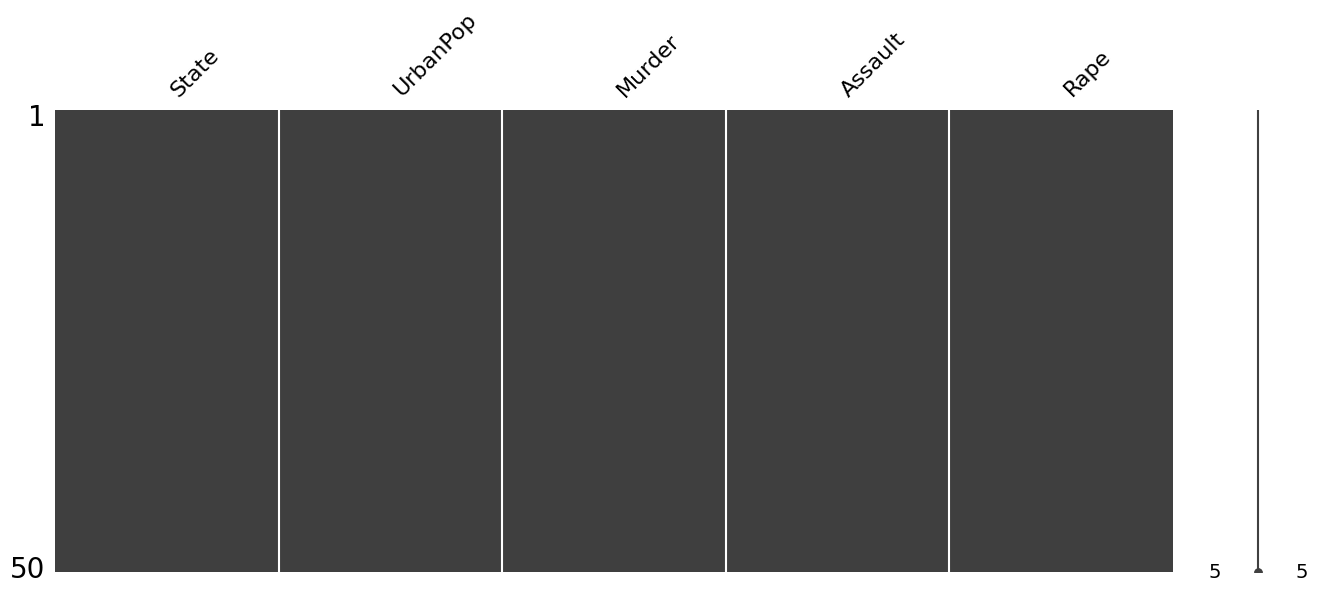

In [59]:
# We can visualise the dsitribution of missing values in the dataset
import missingno
missingno.matrix(df, figsize=(16,6)); # graph missing values

In [60]:
# ... let's be sure there are none, as the above vis suggests
df.isnull().sum() # count any values missing from each feature

State       0
UrbanPop    0
Murder      0
Assault     0
Rape        0
dtype: int64

#### We will need to scale the data

In [61]:
# Let's get stats about the data
df.describe()

,UrbanPop,Murder,Assault,Rape
count,50.000000,50.00000,50.000000,50.000000
mean,65.540000,7.78800,170.760000,21.232000
std,14.474763,4.35551,83.337661,9.366385
min,32.000000,0.80000,45.000000,7.300000
25%,54.500000,4.07500,109.000000,15.075000
50%,66.000000,7.25000,159.000000,20.100000
75%,77.750000,11.25000,249.000000,26.175000
max,91.000000,17.40000,337.000000,46.000000


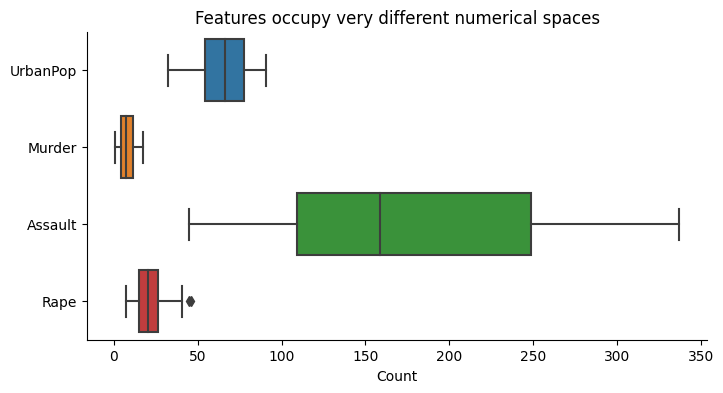

In [62]:
# Of note - the features occupy very different numerical spaces, which will mean we need to scale.
# Let's quickly visualise this:

plt.figure(figsize=(8,4))
sns.boxplot(data=df, orient='h')
sns.despine()
plt.title('Features occupy very different numerical spaces')
plt.xlabel('Count');

## Correlation Analysis
Let's visualise any correlation between features with a heatmap.  We would want to reduce or remove redundant data to speed our calculations.

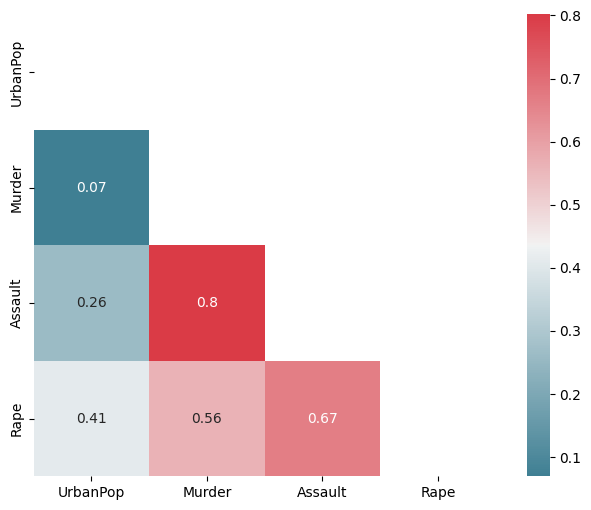

In [63]:
# Create heatmap of any correlation between numerical features

colormap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, annot=True, square=True, cmap=colormap);

## There is correlation

There is positive correlation between the crime types.  In particular, there is a very strong correlation between Assualt and Murder.

In a dataset with a large number of features we might consider dropping a given feature if it is highly correlated to another, as the effect on the final predictions of each will be similar, ie one makes the other redundant, we do not need both.  But in a small dataset such as this one, that would be too drastic, ie we would lose far too high a proportion of the dataset by doing so.

## So let's use PCA

Instead let's use PCA, ie Principal Component Analysis.  This reduces dimensionality of a dataset by producing composite features known as principal components, to use instead of the original features.  These principal components are uncorrelated with one another, meaning the redundancy indicated by correlation between the original features in the original dataset is no longer present.  The new dataset is smaller and therefore faster to work with, while remaining sufficiently representative of the original.

Another way of thinking of PCA: it allows us to define new components for a dataset that describe what is actually happening in the data.

And another:  it will synthesize variables which encode similar types of differences into fewer dimensions, ie fewer variables.

And one more:  it will find the underlying variables, ie principal components, that best differentiate the observations by determining the directions along which the data points are most spread out. 

In [64]:
# At this point we need to scale, as identified earlier 
X = StandardScaler().fit_transform(df.values[:, 1:5])
# X = StandardScaler().fit_transform(df.iloc[:, 1:5]) # %%timeit shows iloc much slower here

# Apply PCA to scaled features 
pca = PCA().fit(X)

### About Variance
PCA works by assessing variation in the dataset. Eigenvectors are used to calculate the principal components (PCs), which are new axes that capture the most important information, ie the variance, in the data.

The first PC captures the maximum possible variance in the original data, while each subsequent PC captures as much of the remaining variance as possible. The amount of variance captured by each PC can be used as a measure of its importance in explaining the variation in the data. Higher variance in a PC means that it explains a larger proportion of the variability in the data compared to PCs with lower variance.

Because each subsequent PC is less significant, we can choose how many of them to use.  Typically, we look for the total cumulative variance of our PCs to be between 80% and 90%.  The absolute minimum might be 60% - the lower the value the more there is danger of introducing bias.

In [65]:
# Get Explained Variance Ratio, which measures the importance of each Principal Component
evr = pca.explained_variance_ratio_ 
 
evr

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

From our ratios we see PC1 contains 62% of all explained variance within our data.  PC2 adds a further 24.74%, which takes us above our chosen 85% threshold.  Let's graph this as well:

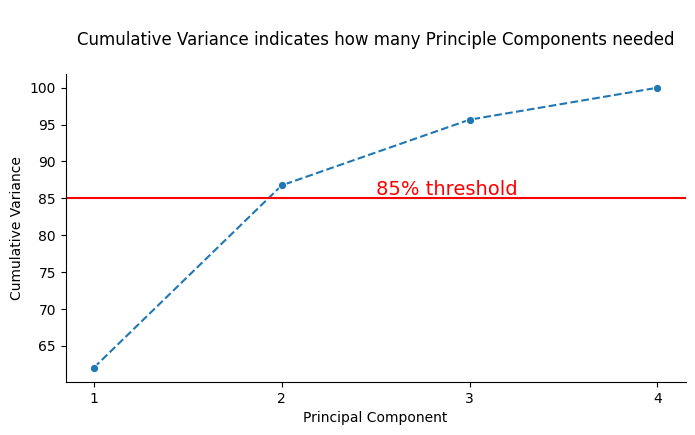

In [66]:
# To visualise how many Principal Components we need in our final PCA, lets graph the cumulative addition of their Explained Variance Ratios

plt.figure(figsize=(8,4))

axis_x = np.arange(1, len(evr)+1, step=1)   # create graph values in X direction
axis_y = np.cumsum(evr)*100                 # create graph values in Y by cumulative additition of Explained Variance Ratio
sns.lineplot(x=axis_x, y=axis_y, linestyle='--', marker='o')
sns.despine()
plt.title('\nCumulative Variance indicates how many Principle Components needed\n')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance')
plt.xticks(axis_x)

plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color='red', fontsize=14);

So we can move forward with just two Principle Components, meaning we've halved the amount of data we're working with when compared with the four features of the original dataset. This is a significant dimensionality reduction.

In [67]:
# Generate PCA model with two Prinipal Components
pca = PCA(n_components = 2)

# Fit our data to the PCA model to get our Principal Components 
principle_components = pca.fit_transform(X)

# put the Components in a DataFrame
pca_df = pd.DataFrame(principle_components, index=df.index, columns=['PC1', 'PC2'])
pca_df.insert(0, 'State', df.State)

pca_df.head()

,State,PC1,PC2
0,Alabama,0.985566,1.133392
1,Alaska,1.950138,1.073213
2,Arizona,1.763164,-0.745957
3,Arkansas,-0.141420,1.119797
4,California,2.523980,-1.542934


To demonstrate/validate that our Principal Components are not correlated, and therefore contain no redundancy, ie are truly independant:

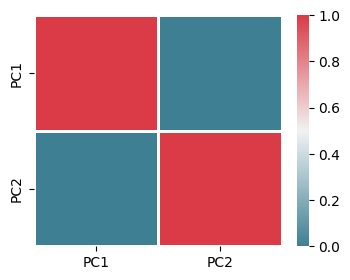

In [68]:
# this heatmap is to confirm/demonstrate that the remaining features are truly independant

plt.figure(figsize=(4,3))
sns.heatmap(pca_df.corr(numeric_only=True), cmap=colormap, linewidth=1);

For interest's sake we can also plot correlation of principal components to original features:

<AxesSubplot: >

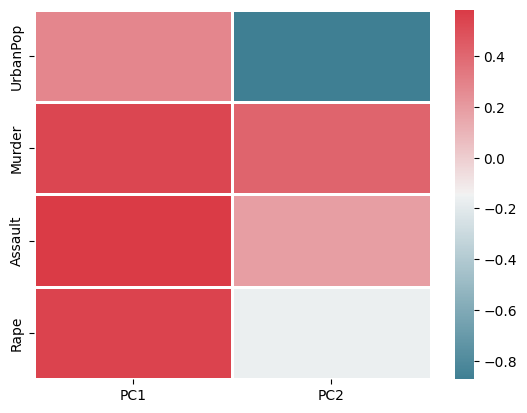

In [69]:
# Plot a post-PCA heat-map to show correlation of the PCA-generated features to the originals
components = pd.DataFrame(pca.components_, columns=df.columns[1:5], index=['PC1', 'PC2']).transpose() # columns=df.columns[1:5] to remove State
sns.heatmap(components, cmap=colormap, linewidth=1)

Next let's look at how the variance is encapsulated in our Principal Components:

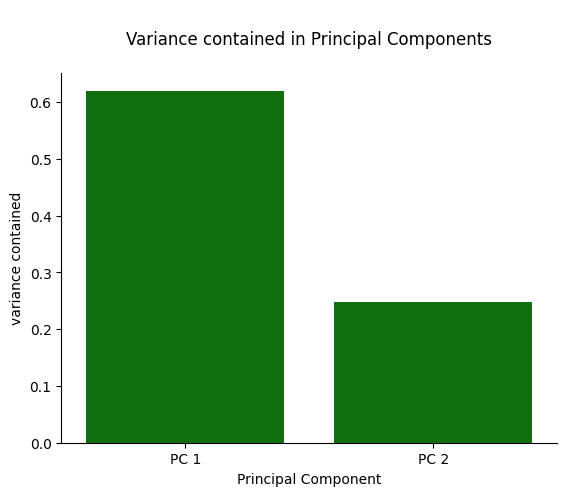

In [70]:
# Make DataFrame of explained variance ratios of principal components
df_eva = pd.DataFrame({'variance contained': pca.explained_variance_ratio_, 'Principal Component': ['PC 1', 'PC 2']})

sns.barplot(df_eva, x='Principal Component', y='variance contained', color='g')
plt.title('\nVariance contained in Principal Components\n')
sns.despine()


To further illustrate, let's use a biplot to represent Components within the total DataFrame

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


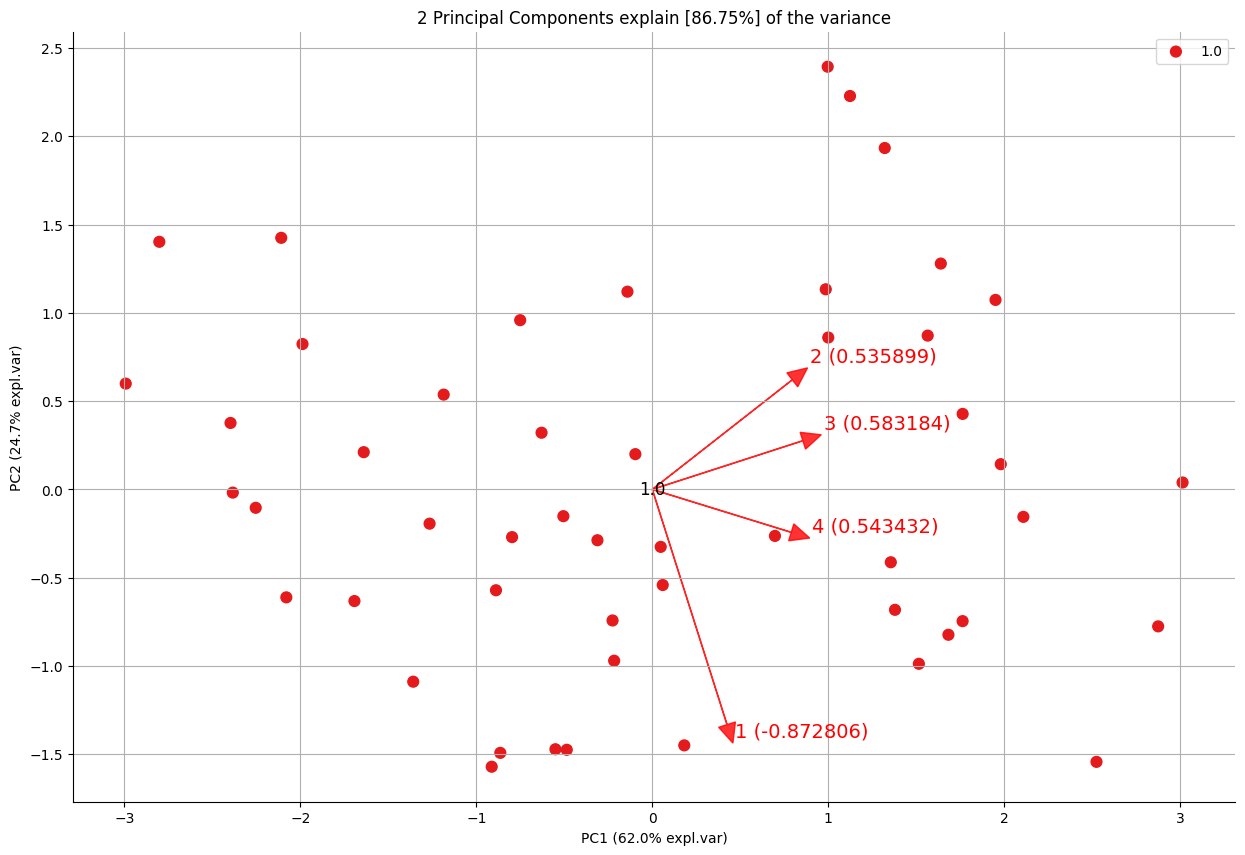

In [71]:
from pca import pca as p_c_a    # this alternative PCA function usefully includes 'biplot' so we don't have to write our own
model = p_c_a(n_components=2)             
results = model.fit_transform(X)

model.biplot(n_feat=4, fontdict={'size':14})
sns.despine()

The above shows each State plotted against the two principal components.  The vectors indicate the four variables, ie Urban Population, Murder, Assault, & Rape.

Each variable has had a positive correlation with the first Principle Component.  The feature componant, 'UrbanPop' denoted here by '1', has respectively the highest correlation with the 2nd principle component.  Additionally, it is the only correlation which is negative.

## Cluster Analysis using Hierarchichal Clustering
We will perform both Hierarchical and K-means clustering with this data and compare the results., starting with hierarchcical.

Hierarchical clustering builds a hierarchy by creating nested clusters iteratively. It starts with individual data points as separate clusters and successively merges them into bigger clusters until all the data points belong to a single cluster or the desired number of clusters is reached. The result is a tree-like representation called a dendrogram, which allows visualization of the clustering structure. Vertical distance in the dendrogram represents distance between clusters.  More distance is better, meaning better demarked clusters.

There are at least six methods, or linkage criterion, for merging the clusters as the dendrogram is built.  We will try three, plotting a dendrogram for each.

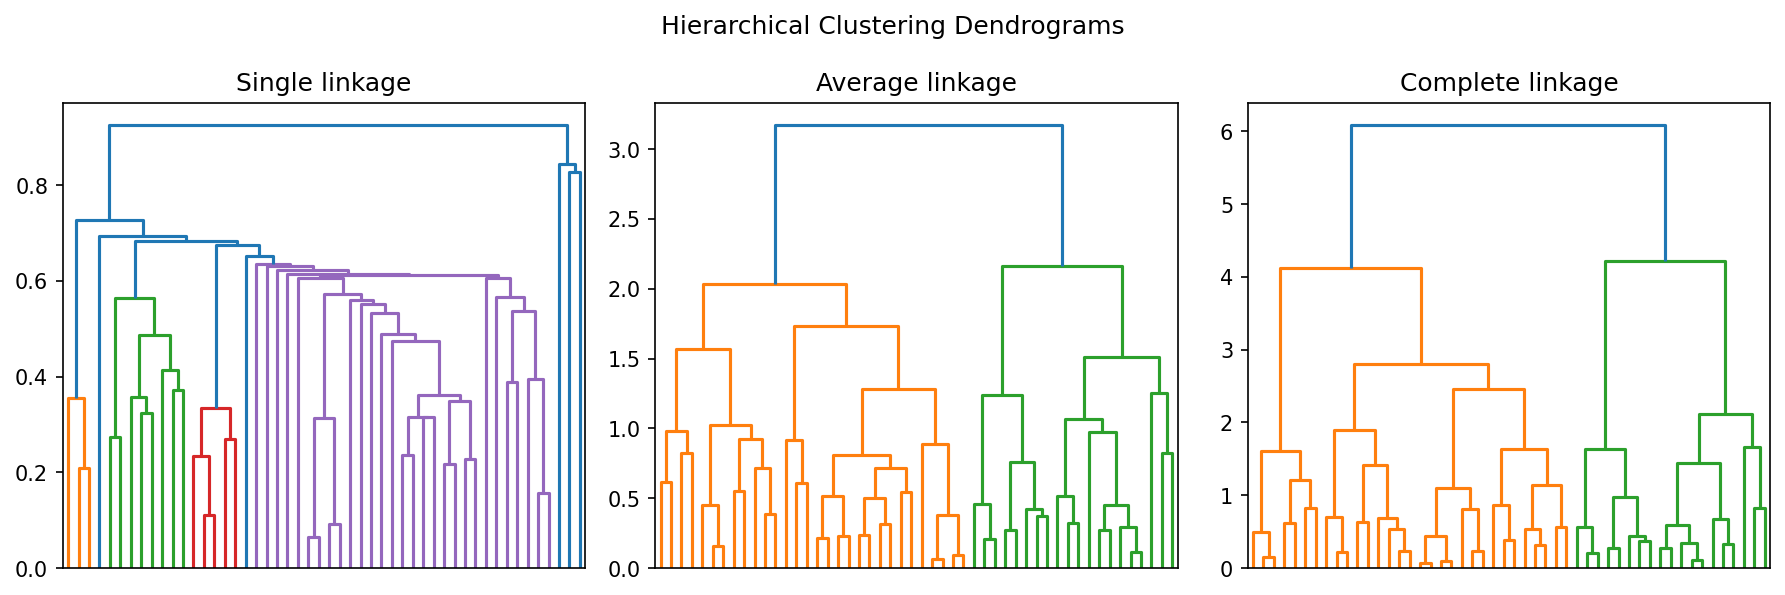

In [72]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans

# drop the response variable
pc_df = pca_df.drop(columns=['State'])              

# fit the data to the Hierachical Clustering model
# Note: 'Agglomerative' refers to hierarchical clustering being a 'bottom-up' method
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pc_df)

# Choose our linkage criterion
methods = ['single', 'average', 'complete']

# plot three dendrograms, one for each linkage method
plt.figure(figsize=[12,4], dpi=150)
plt.suptitle('Hierarchical Clustering Dendrograms')

for plot, m in enumerate(methods):
    fig = plt.subplot(1, len(methods), plot+1)        # put next axes into grid of plots ready for dendrogram
    dendrogram(linkage(pc_df, method=m))
    plt.title(f'{m.capitalize()} linkage')
    fig.set_xticks([])                                # remove x-axis info as it would be unreadable
plt.tight_layout()

Of these, the average linkage appears to work best with this dataset. K, the number clusters at which the dendrogram should be cut, will be 2.  But to be sure lets also try some other K values:

In [73]:
# Our chosen value of 2 for K, the number of clusters, informed by the complete linkage dendrogram
# (and some other K values for comparison)
chosen_K = {2:0, 3:0, 4:0, 5:0}

print('Silhouette score for ', end='')
for K in chosen_K.keys():

    cluster = AgglomerativeClustering(n_clusters=K, linkage='average')
    cluster.fit_predict(X)

    chosen_K[K] = round(silhouette_score(X, cluster.labels_, metric='euclidean'), 2)
    print(f'{K} clusters: {chosen_K[K]}', end=', ' )

Silhouette score for 2 clusters: 0.41, 3 clusters: 0.35, 4 clusters: 0.36, 5 clusters: 0.32, 

While the dendrogram gives great visual insight into the clustering achieved, numerical scores are valuable.

### About Silhouette score

The Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high silhouette score indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. A silhouette score of 0 indicates that the object may be on or near the decision boundary between two clusters.

Our silhouette scores show that hierarchical clustering into two clusters is most appropriate for this dataset, which matches the visual info from the dendrogram.

## Cluster Analysis using K-Means Clustering

K-Means Clustering partitions a dataset into k clusters, where k is a user-defined number. It works by iteratively assigning each data point to the closest of k centroids and then re-calculating the centroids as the mean of the assigned data points, until the centroids no longer change. The algorithm aims to minimize the sum of squared distances between each data point and its assigned centroid. The result is a partitioning of the data into k clusters.

K-Means is fast and efficient for large datasets, but its results can be sensitive to the initial choice of centroids and the number of clusters, k.

To help choose k we can use the Elbow method, which is a heuristic for determining the optimal number of clusters. It involves plotting the sum of squared distances for each possible value of k and selecting the "elbow" point in the graph, where adding more clusters does not result in significant improvement.

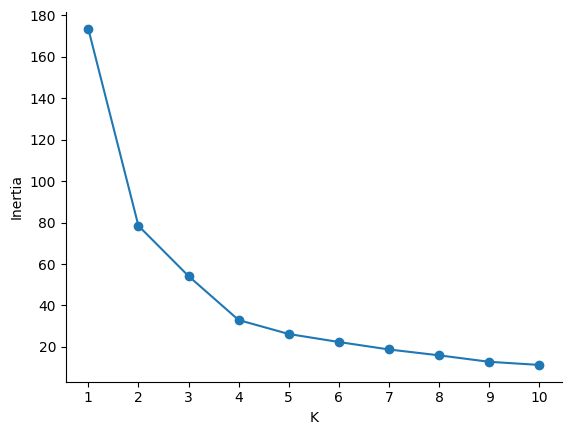

In [74]:
def eval_kMeans(x, k, r):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_kMeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_kMeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, max_k+1), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.xticks(np.arange(1, max_k+1))
    plt.ylabel('Inertia')
    sns.despine()

elbow_kMeans(pc_df)

The elbow runs from 2 to 4, so we will use each for k and compare silhouette scores. 

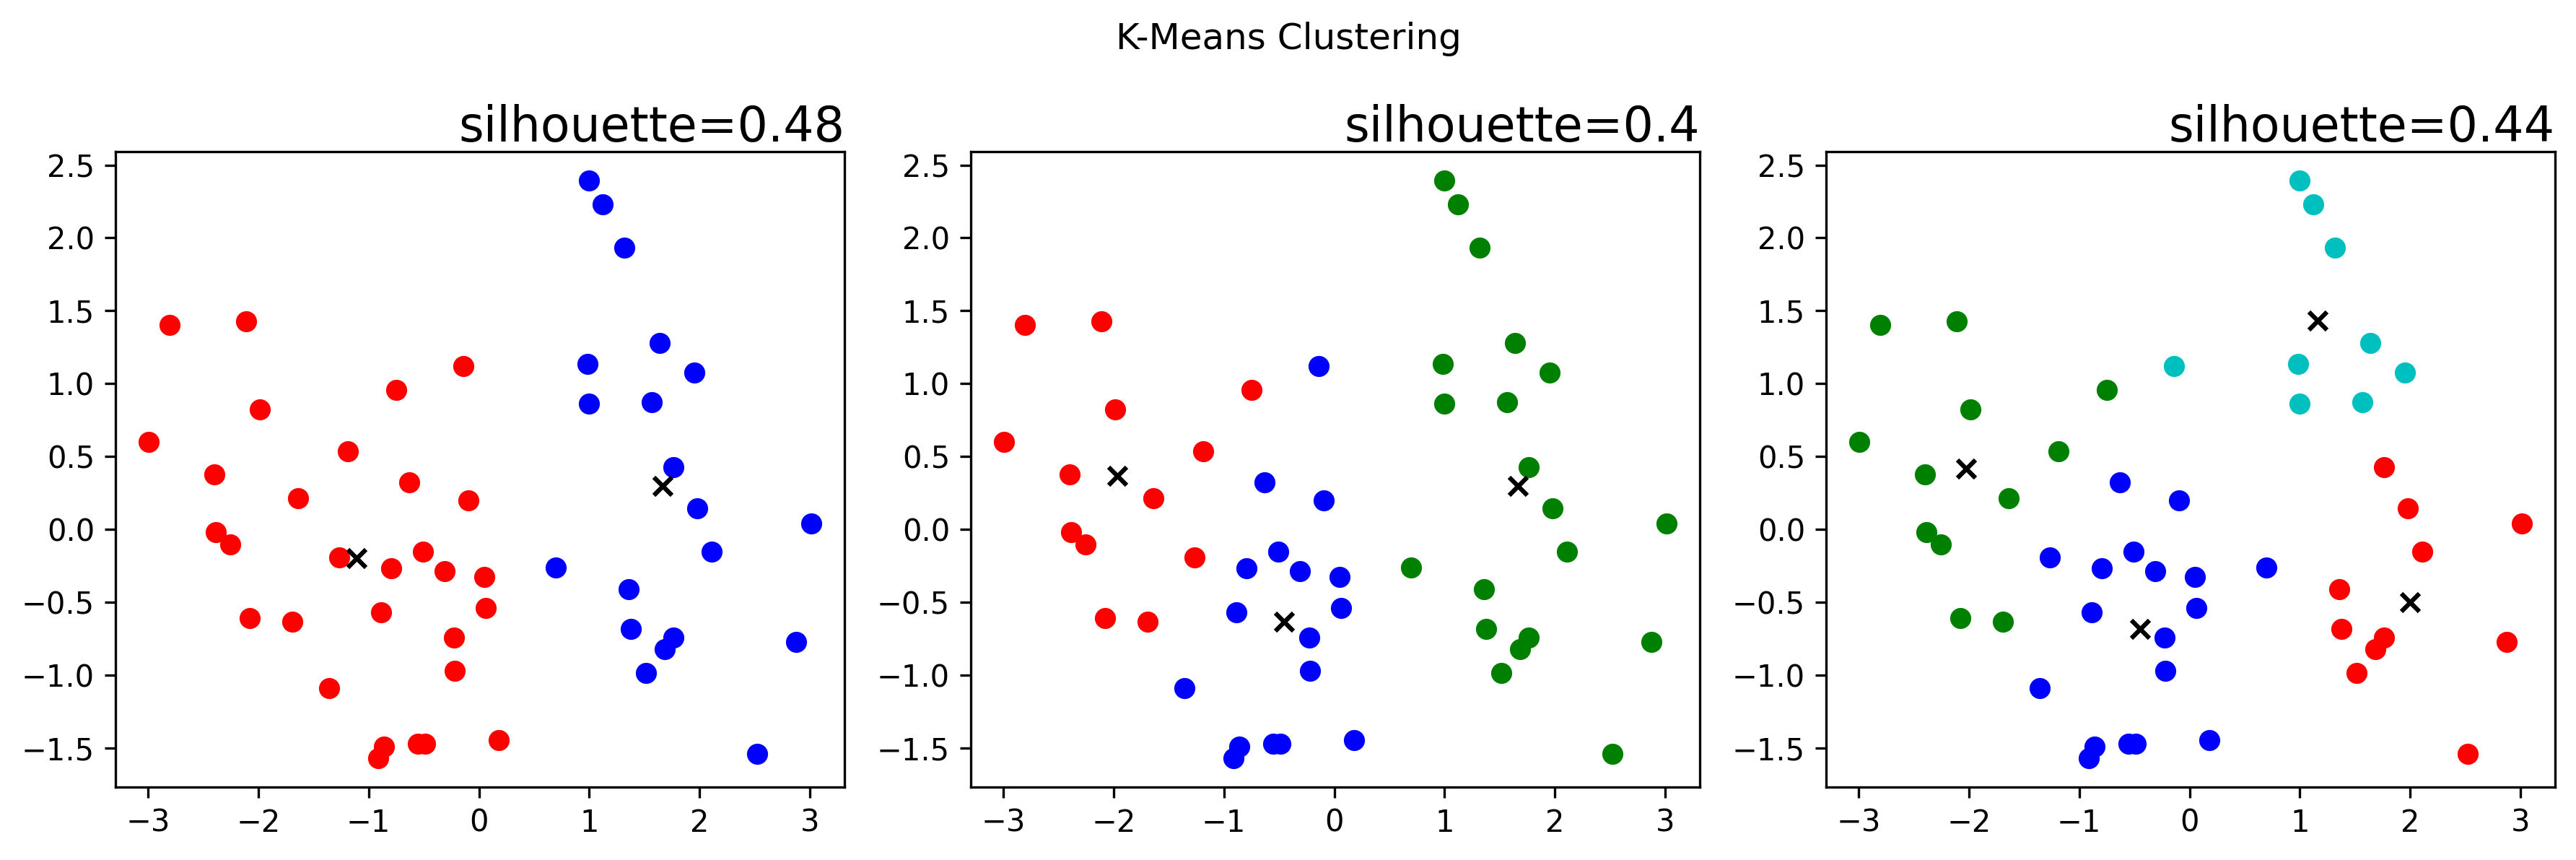

In [88]:
def scatter_kMeans(x, k, r=123):
    '''plots clusters and silhouette score'''

    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'

    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)



# We need to reconfigure the data for the k-Means algorithm
X = pc_df.values.reshape(-1,2)

# before we call scatter_kMeans with each of the k values
plt.figure(figsize=[12,4], dpi=300)
plt.suptitle('K-Means Clustering')
plot = 0
for k in range(2,5):
  plot += 1
  fig = plt.subplot(1, 3, plot)
  scatter_kMeans(X, k, r=0)
plt.tight_layout(h_pad=20);

## So in conclusion

Performing unsupervised learning using each of these two clustering methods, hierarchical clustering and k-means clustering, resulted in a best result using two clusters each time.

K-means did slightly better for this dataset, according to silhouette score.